# Hate Speech Project

## Introduction

__Hate speech__ is defined by the _Cambridge Dictionary_ as "_public speech that expresses hate or encourages violence towards a person or group based on something such as race, religion, sex, or sexual orientation_".[[1](https://dictionary.cambridge.org/us/dictionary/english/hate-speech)]  
Hate speech is "_usually thought to include communications of animosity or disparagement of an individual or a group on account of a group characteristic such as race, colour, national origin, sex, disability, religion, or sexual orientation_".[[2](http://southernlibrarianship.icaap.org/content/v09n02/brown-sica_m01.html#_edn2)]  
A legal definition of hate speech varies from country to country.

Source: [Wikipedia article on "Hate speech"](https://en.wikipedia.org/wiki/Hate_speech)

Given the huge amount of user-generated contents on Twitter, the problem of detecting, and therefore possibly contrasting the HS diffusion, is becoming fundamental, for instance for fighting against misogyny and xenophobia. To this end, in this task, we aim at identifying possible hate speech spreaders on Twitter as a first step towards preventing hate speech from being propagated among online users.  

The project's idea is __to develop a model that can determine whether its author spreads hate speech, given a Twitter feed__.

## Dataset description

The dataset contains timelines of users sharing hate speech towards, for instance, immigrants and women, __100 training cases / authors__ each (with __100 tweets per author__).

The data directory contains __a XML file per author (Twitter user)__.

The name of the XML file corresponds to the unique autor id.

Moreover, a `truth.txt` file with the list of authors and the ground truth. The format of the XML files and the `truth.txt` are as follows:

__Author file (XML)__:
```xml
<author lang="en>
    <documents>
        <document>Tweet 1 textual contents</document>
        <document>Tweet 2 textual contents</document>
        ...
    </documents>
</author>
```

__Truth file__:
```
639b8e5e6a527d494c85d8f5704b1a01:::0
f2b1fc84c500c38a93522efbd422b559:::0
10b2d013382e1fb3c9414ea28329f258:::0
26644d1348fc1122e8c5ef45d6bc84fa:::0
4d4c5dcbfe38d0d33a0d1b1419952ca8:::0
86a7f84c2dd126dac46270b6c912952c:::0
88d8ac4ae2d91e681ee8a8d3b60fd911:::0
2a9776a2909ba5e27043faf2d57ba410:::0
fdb47a3f65091b9a5b989e1722c9fac4:::0
5625ca3bc44c89d763221b663f7c0987:::0
```

## Mission

__The final objective is to build a system that can predict if a user in social media is a hate speech spreader or not.__

The output of the system can be used as a filtering module in online social media.

## Tasks

Following tasks need to be accomplished:
1. Understand the content that is available in the dataset .
2. Pre-process the data to improve the final results.
3. Baseline model
4. LSTM model
5. Compare the results of both models using the F1 measure.
6. _(Optional)_ Think about further steps to improve your performance, such as pre processing, feature embeddings, post processing etc. and try them out if you have time.

# Python imports

In [1]:
# Data loading
import os
import pandas as pd
import re

# Data parsing
from tqdm import tqdm
from xml.dom import minidom

# EDA
import matplotlib.pyplot as plt
import seaborn as sns


# Data loading

We need to parse lots of XML files and add everything into a huge pandas DataFrame.  
So the idea is as follows:
* for each language `("en", "es")`
* for each author / file
* read all tweets

In [2]:
data_dir="/work/data"

## Reading tweets from a given file

In [3]:
# Testing the XML parsing of a file
xml_file=open(data_dir + "/en/043e2766cc6d22ae4e447ca5f2885a2a.xml")

# Setting up parser for the file
parser = minidom.parse(xml_file)

In [4]:
# Using the parser to get first [0] tweet
tweet = parser.getElementsByTagName('document')[0].firstChild.wholeText

print(tweet)

Fuck New York #URL#


In [5]:
tweets = parser.getElementsByTagName('document')

for tweet in tweets:
    print(tweet.firstChild.wholeText)

Fuck New York #URL#
#USER# #USER# I think I'm in love
Trump is awesome #URL#
#USER# You have the greatest tweets sweetheart #USER#
#USER# It's free pizza Hun, just free food
#USER# Love you Joy
Can I help CNN, I can piss on ya #URL#
She IS a wet potato sack #URL#
#USER# Long gone darlin
I like them too #URL#
RT #USER#: RETWEET if you think Michael Moore is a worthless Loser! #URL#
RT #USER#: Did CNN just re-unite the alt-right &amp; the new right in a common cause? 🤔 #URL#
Oh, a willnot #URL#
RT #USER#: Hey #USER#! Just saw a 12 year old with a video camera and a Trump t-shirt, might want to pay this clown a visit
#USER# is so low, he can crawl under a snake and not alert it, better yet, he's a goof #URL#
Let me get that for ya honey #URL#
I'll eat what the fuck I want #URL#
#USER# you mean this asshole, yep you nailed it, he is an asshole #URL#
Wow #USER# at those jeans #URL#
What USA looks like today #URL#
RT #USER#: TV RATINGS: Fox News has 14 of the top 20 cable news shows in total

## Getting languages and file list

We need to list a content of the data dictionary and assume everything found is a "language" subfolder.  
  
```
(venv) root@deepnote:~/work # ls data
en  es
```  
</br>  
These are two subfolders for English (`"en"`) and Spanish ('"es"`) users.

In [6]:
# We will store the available languages into this "langs" list
langs = []

# Iterate through the data_dir content:
for item in os.listdir(data_dir):
    print(item)
    langs.append(item)

es
en


In [7]:
langs

['es', 'en']

## Loading tweets

Following block will:
  - scan through the `data` directory and for each language found
  - scan all the files (taking only the XML files)
  - read all the tweets
  - append this all into a huge pandas DataFrame  

In [8]:
# Create empty dataframe with specified columns
userid_pattern = "[a-z0-9]{32}"
twitter_file_pattern = userid_pattern + "\.xml"
columns = ["lang", "userid", "tweet"]
data = pd.DataFrame(columns=columns)

# Scan data directory for languages and XML files
for lang in os.listdir(data_dir):
    
    # Scan files in language directory
    for item in tqdm(os.listdir(data_dir + "/" + lang), desc=f"Loading files [{lang}]..."):
        
        # Twitter XML file filter:
        if re.search(twitter_file_pattern, item):

            # Extract userid from file name
            userid = item[:-4]

            # Open XML file and setup parser
            xml_file = open(data_dir + "/" + lang + "/" + item)
            parser = minidom.parse(xml_file)

            # Parse tweets
            tweets = parser.getElementsByTagName('document')

            # Add each tweet to a dataframe
            for tweet in tweets:
                addition = pd.DataFrame([[lang, userid, tweet.firstChild.wholeText]], columns=columns)
                data = data.append(addition, ignore_index=True)

Loading files [en]...: 100%|██████████| 201/201 [03:02<00:00,  1.10it/s]


The processing of the XML files took ~5 minutes. To save time I decided to store it later to a CSV file, so next time we can load it very quickly.

In [9]:
data = pd.read_csv("/work/data.csv")

In [10]:
data.head()

,Unnamed: 0,lang,userid,tweet
0,0,es,223d8277fe1f9895a83a385010218989,"#USER# #USER# Me gusta la VALENCIANA, es mucha..."
1,1,es,223d8277fe1f9895a83a385010218989,RT #USER#: La crítica de Pablo Echenique a Isa...
2,2,es,223d8277fe1f9895a83a385010218989,RT #USER#: Errejón se prepara la moción 😂😂😂😂😂😂...
3,3,es,223d8277fe1f9895a83a385010218989,#USER# #USER# #USER# #USER# #USER# Y esos insu...
4,4,es,223d8277fe1f9895a83a385010218989,RT #USER#: #USER# #USER# #USER# Sí Sí igual qu...


## Loading truth

In [11]:
# Testing for presence of a "truth.txt" file
[item for item in os.listdir(data_dir + "/" + lang) if item=="truth.txt"]

['truth.txt']

Following block will load all truth files:

In [12]:
# Create empty dataframe with specified columns
truth_file_name = "truth.txt"
columns = ["userid", "truth"]
truth = pd.DataFrame(columns=columns)

# Scan data directory for languages and XML files
for lang in langs:
    
    # Scan files in language directory
    for item in tqdm(
        [item for item in os.listdir(data_dir + "/" + lang) if item=="truth.txt"],
        desc=f"Loading truth files [{lang}]..."):
        
        addition = pd.read_csv((data_dir + "/" + lang + "/" + item), sep=":", index_col=False, usecols=[0,3], names=columns)

        truth = truth.append(addition, ignore_index=True)

Loading truth files [en]...: 100%|██████████| 1/1 [00:00<00:00, 159.22it/s]


In [13]:
truth

,userid,truth
0,1a698d93874644625d83a76b206c7aa3,0
1,b7200193802bde3769f4daa371b5305b,0
2,7ffb758291340303c2162fcee25e2780,0
3,e309e9e2516824370310661c919dd5d8,0
4,b523abc590889dfaf69a1c8470ef314d,0
...,...,...
395,833ffc26e9f1a81265e3e97513cefb86,1
396,dead14502e55f545546f666ab6d91558,1
397,e608b622e6a3085290fc279b55fa821c,1
398,a7d4e6f2aa8543a448b5a07feab9fc49,1


The point is that the label (truth) is 1 per each _author_, not per _tweet_. We have think about how to organize the data for the NN classifier.

If we ever needed to merge `data` and `truth` dataframes together, this is how we could do it:

In [14]:
# data = data.merge(right=truth, how="left", on="userid")

Now I will save the DataFrames, so we can load them up much quicker after the hardware resets.

In [15]:
# Commented out after controlled run, so we have done the files right
# data.to_csv("data.csv")
# truth.to_csv("truth.csv")

# Exploratory Data Analysis

## Re-loading both data sets

In [16]:
data = pd.read_csv("data.csv", index_col=0)
truth = pd.read_csv("truth.csv", index_col=0)

In [17]:
data

,lang,userid,tweet
0,es,223d8277fe1f9895a83a385010218989,"#USER# #USER# Me gusta la VALENCIANA, es mucha..."
1,es,223d8277fe1f9895a83a385010218989,RT #USER#: La crítica de Pablo Echenique a Isa...
2,es,223d8277fe1f9895a83a385010218989,RT #USER#: Errejón se prepara la moción 😂😂😂😂😂😂...
3,es,223d8277fe1f9895a83a385010218989,#USER# #USER# #USER# #USER# #USER# Y esos insu...
4,es,223d8277fe1f9895a83a385010218989,RT #USER#: #USER# #USER# #USER# Sí Sí igual qu...
...,...,...,...
79995,en,e9f06b27f1108050bd27937cbacb1d5e,#USER# #USER# biden raises the dead again
79996,en,e9f06b27f1108050bd27937cbacb1d5e,and has a ———-for a running mate🤮 America has ...
79997,en,e9f06b27f1108050bd27937cbacb1d5e,#USER# should have been done ✅ fair and square...
79998,en,e9f06b27f1108050bd27937cbacb1d5e,#USER# #USER# bullshit...they “found” them pho...


In [18]:
truth

,userid,truth
0,1a698d93874644625d83a76b206c7aa3,0
1,b7200193802bde3769f4daa371b5305b,0
2,7ffb758291340303c2162fcee25e2780,0
3,e309e9e2516824370310661c919dd5d8,0
4,b523abc590889dfaf69a1c8470ef314d,0
...,...,...
395,833ffc26e9f1a81265e3e97513cefb86,1
396,dead14502e55f545546f666ab6d91558,1
397,e608b622e6a3085290fc279b55fa821c,1
398,a7d4e6f2aa8543a448b5a07feab9fc49,1


So we're having actually:
* 2 languages (Spanish, English)
* 200 authors per language
* 200 tweets per author

Which equals:
* 400 authors total
* 80000 tweets total
* 400 binary labels

## Class balance

We have fairly balanced classes:

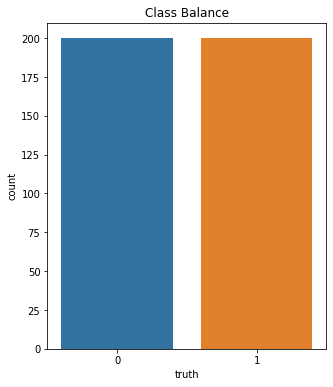

In [19]:
fig, ax = plt.subplots(figsize=(5,6))

ax = sns.countplot(x="truth", data=truth)
ax.set_title("Class Balance")

plt.show()


## Missing values

Check for missing values in `data`:

In [20]:
data.isna().sum().sum()

0

Check for missing values in `truth`:

In [21]:
truth.isna().sum().sum()

0

Check for missing truth assignments (both directions):

In [22]:
pd.merge(left=data, right=truth, how="left", on="userid").isna().sum().sum()

0

In [23]:
pd.merge(left=data, right=truth, how="right", on="userid").isna().sum().sum()

0

## Multiplicated tweets

In [24]:
# Check multiplicated tweets
duplicates = data["tweet"][data["tweet"].duplicated(keep=False)].value_counts()

#duplicates["count"]=1

duplicates.head(50)

one person followed me // automatically checked by #URL#                                                                      91
one person unfollowed me // automatically checked by #URL#                                                                    53
2 people followed me // automatically checked by #URL#                                                                        46
I posted a new video to Facebook #URL#                                                                                        43
one person followed me and one person unfollowed me // automatically checked by #URL#                                         33
2 people followed me and one person unfollowed me // automatically checked by #URL#                                           23
3 people followed me // automatically checked by #URL#                                                                        20
From earlier today #URL#                                                                         

### fllwrs tweets removal

It is apparent that largest part of multiplicated tweets come from [fllwrs](http://fllwrs.com/) app, which checks for changes in user's Twitter followers over time. It records followers that have been added or lost.

These tweets don't come from the authors, so they carry no information for our project. I will now remove all tweets that match to certain regular expression and do multiplicative tweets re-check.

In [25]:
fllwrs_pattern = "((one|[0-9]+){1} (person|people){1} (un)?followed me){1}( and (one|[0-9]+){1} (person|people){1} (un)?followed me){0,1} // automatically checked by #URL#"

In [26]:
data[data["tweet"].str.match(fllwrs_pattern)].value_counts("tweet")

tweet
one person followed me // automatically checked by #URL#                                 91
one person unfollowed me // automatically checked by #URL#                               53
2 people followed me // automatically checked by #URL#                                   46
one person followed me and one person unfollowed me // automatically checked by #URL#    33
2 people followed me and one person unfollowed me // automatically checked by #URL#      23
3 people followed me // automatically checked by #URL#                                   20
3 people followed me and one person unfollowed me // automatically checked by #URL#      18
2 people followed me and 2 people unfollowed me // automatically checked by #URL#        14
4 people followed me // automatically checked by #URL#                                   12
2 people unfollowed me // automatically checked by #URL#                                 11
one person followed me and 2 people unfollowed me // automatically checked

So I decided to mark the rows with flag value `"fllwrs"`:

In [27]:
data.loc[data["tweet"].str.match(fllwrs_pattern), ["flag"]] = "fllwrs"

In [28]:
data["flag"].value_counts()

fllwrs    373
Name: flag, dtype: int64

Now I'll re-check for multiplicated tweets, but I will omit the "fllwrs" flag now:

In [29]:
# Check multiplicated tweets
duplicates = data["tweet"][(data["tweet"].duplicated(keep=False)) & (data["flag"].isna())].value_counts()

#duplicates["count"]=1

duplicates.head(60)

I posted a new video to Facebook #URL#                                                                                        43
From earlier today #URL#                                                                                                      19
#USER# Carnival Cruises Must Drop George Lopez For Disgusting Call To Kill The President                                      14
Retweet &amp; Share #URL#                                                                                                     14
#USER# El gran "regenerador" #USER#, que echó a Rajoy por corrupción, brinda su apoyo total a Iglesias y a sus corruptelas    11
#USER# Muslims and Hispanics are taking over the USA with the help of Democrats. Vote Republican !!!                           9
RT #USER#: “...tiene un problema moral.” #URL#                                                                                 9
Political Cartoons - 2020 #URL#                                                                  

### URL (re)posts

Looking at the next biggest clusters have similar idea - user posts and shares an #URL#.

There are some notable clusters:
  * Facebook video re-posts (43 identical tweets: `"I posted a new video to Facebook #URL#"`), which might be a cross-post to Twitter after user uploaded a video to Facebook.
  * Other re-posts or re-shares examples:
    * `"From earlier today #URL#"`
    * `"Retweet &amp; Share #URL#`
    * `"#USER# More info on #HASHTAG# #URL#"`
    * `"#HASHTAG# ! Retweet &amp; Share #URL#"`

The tweets themselves doesn't provide any hate speech related information value as we don't know what kind of content was posted.

Entire URL (re)posts cluster can be cleaned from the data.

__Facebook__:

In [30]:
facebook_pattern = "I posted a new video to Facebook #URL#"

data.loc[data["tweet"].str.match(facebook_pattern), ["flag"]] = "facebook"

data["flag"].value_counts()

fllwrs      373
facebook     43
Name: flag, dtype: int64

__URL reposts__:

In [31]:
urlrepost_pattern = "^(#USER# More info on #HASHTAG#|From earlier today|(#HASHTAG#)? ?.? ?Retweet &amp; Share) #URL#$"

data.loc[data["tweet"].str.match(urlrepost_pattern), ["flag"]] = "url repost"

data["flag"].value_counts()

fllwrs        373
url repost     49
facebook       43
Name: flag, dtype: int64

In [32]:
data[data["flag"]=="url repost"]

,lang,userid,tweet,flag
41941,en,41eff6afb1ced61ab38e4d86d56825e0,#USER# More info on #HASHTAG# #URL#,url repost
41942,en,41eff6afb1ced61ab38e4d86d56825e0,#USER# More info on #HASHTAG# #URL#,url repost
41943,en,41eff6afb1ced61ab38e4d86d56825e0,#USER# More info on #HASHTAG# #URL#,url repost
41944,en,41eff6afb1ced61ab38e4d86d56825e0,#USER# More info on #HASHTAG# #URL#,url repost
41945,en,41eff6afb1ced61ab38e4d86d56825e0,#USER# More info on #HASHTAG# #URL#,url repost
41946,en,41eff6afb1ced61ab38e4d86d56825e0,#USER# More info on #HASHTAG# #URL#,url repost
41947,en,41eff6afb1ced61ab38e4d86d56825e0,#USER# More info on #HASHTAG# #URL#,url repost
41957,en,41eff6afb1ced61ab38e4d86d56825e0,#USER# More info on #HASHTAG# #URL#,url repost
65838,en,e4c296ef32aaf5ca9f293fa3a62a3694,Retweet &amp; Share #URL#,url repost
65839,en,e4c296ef32aaf5ca9f293fa3a62a3694,Retweet &amp; Share #URL#,url repost


# Data pre-processing

## Removing multiplicated tweets

Next step in cleaning of the data is to create a copy of the dataframe where `data["flag"].isna()`. The cleaning would be super easy now.

In [33]:
# Cleaning data:
clean_data = data[data["flag"].isna()].copy()

# Final multiplicates check:
clean_data["tweet"][clean_data["tweet"].duplicated(keep=False)].value_counts().head(30)

#USER# Carnival Cruises Must Drop George Lopez For Disgusting Call To Kill The President                                      14
#USER# El gran "regenerador" #USER#, que echó a Rajoy por corrupción, brinda su apoyo total a Iglesias y a sus corruptelas    11
Political Cartoons - 2020 #URL#                                                                                                9
RT #USER#: “...tiene un problema moral.” #URL#                                                                                 9
#USER# Muslims and Hispanics are taking over the USA with the help of Democrats. Vote Republican !!!                           9
Political Cartoons by AF Branco #URL#                                                                                          8
Buenas noches y buen descanso #URL#                                                                                            8
RT #USER#: Want to thank God for allowing me to see another day...                               

In [34]:
# Flag column is not needed anymore
clean_data.drop(columns=["flag"], inplace=True)

In [35]:
data[~data["flag"].isna()].shape

(465, 4)

In [36]:
clean_data.shape

(79535, 3)

In [37]:
clean_data["tweet"][clean_data["tweet"].duplicated(keep=False)].shape

(2125,)

465 tweets have been removed from the original data, which is ~ 0.6% 🤦‍♂️

There are still 2125 tweets that are multiplied from many reasons. This is ~ 2.67% of the entire set post-cleaning.

Another chance to further clean the data will be after tokenization.

## Tokenization

In [38]:
clean_data.sample(20)

,lang,userid,tweet
19523,es,fcbf05edac41e047fdb8d721065ec41f,"#USER# #USER# Gracias Beily te queremos, a tu ..."
62915,en,342a27905d2291b55486c257d77265b4,#USER# The Wůhan was released by China intenti...
14332,es,9ba85813abc8a8e5ba071d33a9a619a5,#USER# Jajajaja que rebanes más basuras va.
9638,es,fa1a735295b654d2fceeead34dd71d96,#USER# Es más bien IGNORANCIA.
12535,es,dd7364fed881e5ecba9b0d2ec954384b,A ver si esto vale para que traigan un central...
16569,es,7fac4b2a0357eb17c50e8ff47b1b124a,Mi raza es blanca y muy orgulloso. Nadie va a ...
27884,es,5c99a0013236d189a18ca6269ea75d10,#USER# #USER# #USER# #USER# Que les den a todo...
3067,es,38b1490646422a7cce90c7d4e4f57658,#USER# Hay que preguntar si tiene novio y su s...
16939,es,0e4a0376e41eb7d90b28cd08cdb4a844,El carrusel no se para sigue girando
75966,en,c8006e782052410e43cdcdda668d11c4,Yes #USER# #USER# there is more to cricket tha...


In [39]:
# text cleaning

def clean_text(text):
  # get rid of all unwanted punctuation and digits
  text = text.replace("´", "'")
  # get rid of all hashtags
  text = text.replace("RT #USER#:", "")
  text = re.sub( "#[A-Z]*#", " ", text)

  digi_punct = "[^a-zA-Z'óúíáéñ ]"  # óúí... are in the spanish alphabet
  text = re.sub(digi_punct, " ", text)

  text = " ".join(text.split())
  text = text.lower()

  return text

clean_data['tweet_cleaned'] = clean_data['tweet'].apply(clean_text)

In [40]:
clean_data.sample(20)

,lang,userid,tweet,tweet_cleaned
24884,es,d0feaf7314acfc9272b75f936e12de3c,#USER# Árbitro de la elegancia.,rbitro de la elegancia
63932,en,b7f4ead8c975203082dcea622621d2c3,RT #USER#: women in their 30’s be looking amaz...,women in their s be looking amazing so that gi...
26730,es,a0535c6e71eaeccc46c55eec2033c422,RT #USER#: Hacer una pintada en una carretera ...,hacer una pintada en una carretera es fascismo...
66139,en,99cb2cd23f7cf613d394502d17dedad0,"RT #USER#: Bro you seen this man, that dog gun...",bro you seen this man that dog gunna be his be...
29458,es,3513fd8fef887f0569151f9ce534acde,RT #USER#: palavecino ya es ídolo #URL#,palavecino ya es ídolo
37095,es,88cf4c881e19ba3a02c4e84521db65cc,"#USER# D. E. P, Mi más sincero pésame 🙏🙏🙏",d e p mi más sincero pésame
75902,en,c8006e782052410e43cdcdda668d11c4,#USER# #USER# Postal ballots are open to fraud,postal ballots are open to fraud
45531,en,5b50fcecc61c850e961ff307bdce67a0,#HASHTAG# just me or does ch 9 soon not happy ...,just me or does ch soon not happy that storm won
64757,en,cb7b2b7612c3d7ca299387a47393f7e9,RT #USER#: #USER# As do we. #URL#,as do we
37159,es,88cf4c881e19ba3a02c4e84521db65cc,#USER# #USER# Yo he visto hasta amas de casa h...,yo he visto hasta amas de casa hacer la compra...


## Remove stopwords

In [41]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
print(stopwords.words("english"))
print(stopwords.words("spanish"))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [42]:
esen_stopwords = stopwords.words("english") + stopwords.words("spanish")

clean_data["tweet_nostopw"] = clean_data["tweet_cleaned"].apply(
    lambda text: " ".join([word for word in text.split() if word not in esen_stopwords]))

In [43]:
clean_data.sample(10)

,lang,userid,tweet,tweet_cleaned,tweet_nostopw
76519,en,f8bce0042a6c8fcfdb585a052e998afb,Patriarchy's ass kissers are boring me.,patriarchy's ass kissers are boring me,patriarchy's ass kissers boring
31030,es,f46ab3d2949d86b20afc5de5223370bd,RT #USER#: Altas ganas de gastarme toda la pla...,altas ganas de gastarme toda la plata en ropa ...,altas ganas gastarme toda plata ropa boca
4540,es,879a18d0695eef3d0bd1d691d1404eb4,#USER# ¿Imprimir? ¿Esto es una broma o qué? Y ...,imprimir esto es una broma o qué y dicen que é...,imprimir broma dicen éste doctor economía válg...
65716,en,c129b2cf075e1872a86ce8f7473819af,#USER# #USER# Facts don't care about your feel...,facts don't care about your feelings ben shapiro,facts care feelings ben shapiro
72359,en,0d02a3f644c9313315ecc6655ccfa3b9,#HASHTAG# So black history month is in August ...,so black history month is in august now and no...,black history month august february ok
66297,en,98c59ff3e2cfc56b96ee3c49b3d46296,Dave an article for you #URL# #URL#,dave an article for you,dave article
79842,en,e9f06b27f1108050bd27937cbacb1d5e,#USER# #USER# she be after that sucker,she be after that sucker,sucker
14959,es,c69cd94c9f17dbeaf285b5bfe960c25d,RT #USER#: Ladrones. Roban dinero público para...,ladrones roban dinero público para comprar apl...,ladrones roban dinero público comprar aplausos...
36266,es,d2f55b018c8dac971c33c8dcfc6b9b48,El nuevo Ford Mustang SUV #URL#,el nuevo ford mustang suv,nuevo ford mustang suv
32668,es,00c1418fce0e39063eee22ec3e5179ec,"RT #USER#: Algo habría hecho, todos sabemos qu...",algo habría hecho todos sabemos que las mujere...,hecho sabemos mujeres absolutamente incapaces ...


## Lemmatization

In [44]:
!pip install -U spacy
!python -m spacy download en_core_web_sm
!python -m spacy download es_core_news_sm

Requirement already up-to-date: spacy in /shared-libs/python3.7/py/lib/python3.7/site-packages (3.2.0)
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
2021-11-24 18:22:24.938840: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-24 18:22:24.938897: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
     |████████████████████████████████| 13.9 MB 28.3 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
2021-11-24 18:22:37.824715: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerr

In [46]:
import spacy
nlp_es = spacy.load('es_core_news_sm')
nlp_en = spacy.load('en_core_web_sm')

def lemmatizer(text, nlp=nlp_en):  
  doc = nlp(text)
  return ' '.join([word.lemma_ for word in doc])

clean_data['tweet_lemmatized'] = ''

clean_data['tweet_lemmatized'][clean_data['lang']=='en'] = clean_data['tweet_nostopw'][clean_data['lang']=='en'].apply(lambda x: lemmatizer(x, nlp_en))
clean_data['tweet_lemmatized'][clean_data['lang']=='es'] = clean_data['tweet_nostopw'][clean_data['lang']=='es'].apply(lambda x: lemmatizer(x, nlp_es))


In [72]:
clean_data.head(20)

,Unnamed: 0,lang,userid,tweet,tweet_cleaned,tweet_nostopw,tweet_lemmatized
0,0,es,223d8277fe1f9895a83a385010218989,"#USER# #USER# Me gusta la VALENCIANA, es mucha...",me gusta la valenciana es mucha mujer,gusta valenciana mucha mujer,gustar valenciano mucho mujer
1,1,es,223d8277fe1f9895a83a385010218989,RT #USER#: La crítica de Pablo Echenique a Isa...,la crítica de pablo echenique a isabel díaz ay...,crítica pablo echenique isabel díaz ayuso vuelto,crítica pablo echenique isabel díaz ayuso vuelto
2,2,es,223d8277fe1f9895a83a385010218989,RT #USER#: Errejón se prepara la moción 😂😂😂😂😂😂...,errejón se prepara la moción,errejón prepara moción,errejón preparar moción
3,3,es,223d8277fe1f9895a83a385010218989,#USER# #USER# #USER# #USER# #USER# Y esos insu...,y esos insultos soy muchas cosas pero gili no,insultos muchas cosas gili,insulto mucho cosa gili
4,4,es,223d8277fe1f9895a83a385010218989,RT #USER#: #USER# #USER# #USER# Sí Sí igual qu...,sí sí igual que en madrid no se dicen medias v...,igual madrid dicen medias verdades,igual madrid decir medio verdad
5,5,es,223d8277fe1f9895a83a385010218989,RT #USER#: Ves a la novia de Antonio Baños y e...,ves a la novia de antonio baños y entiendes su...,ves novia antonio baños entiendes gusto sexo e...,v novia antonio baño entiend gusto sexo escato...
6,6,es,223d8277fe1f9895a83a385010218989,RT #USER#: #HASHTAG# | 27 millones de dólares ...,millones de dólares pagará ee uu a la familia ...,millones dólares pagará ee uu familia george f...,millón dólares pagar ee uu familia george floyd
7,7,es,223d8277fe1f9895a83a385010218989,#USER# #USER# A mi me parece que no debería se...,a mi me parece que no debería ser legal,parece debería ser legal,parecer deber ser legal
8,8,es,223d8277fe1f9895a83a385010218989,RT #USER#: Interior acerca al País Vasco al as...,interior acerca al país vasco al asesino de ca...,interior acerca país vasco asesino carpena por...,interior acerca país vasco asesino carpena por...
9,9,es,223d8277fe1f9895a83a385010218989,RT #USER#: Sánchez rescata con 53 millones de ...,sánchez rescata con millones de dinero público...,sánchez rescata millones dinero público españo...,sánchez rescatar millón dinero público español...


In [ ]:
#it is time to save the data frame in a file
clean_data.to_csv('/work/clean_data.csv')

In [84]:
clean_data = pd.read_csv('/work/clean_data.csv',index_col=False, )
clean_data.drop('Unnamed: 0', axis=1, inplace=True)
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79535 entries, 0 to 79534
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   lang              79535 non-null  object
 1   userid            79535 non-null  object
 2   tweet             79535 non-null  object
 3   tweet_cleaned     79535 non-null  object
 4   tweet_nostopw     79255 non-null  object
 5   tweet_lemmatized  79255 non-null  object
dtypes: object(6)
memory usage: 3.6+ MB


In [86]:
# create data frame with aggregated tweets for the particular tweeters - i.e. concatenate all tweets for him/her
# first strip the single tweets then attach a " " char to the end to keep them separated from the next tweet
clean_data['tweet_lemmatized'] = clean_data['tweet_lemmatized'].apply(lambda text:str(text))
clean_data['tweet_lemmatized'] = clean_data['tweet_lemmatized'].apply(lambda text:str.strip(text))
clean_data['tweet_lemmatized'] = clean_data['tweet_lemmatized'].apply(lambda text:text+' ')

# we want to keep the language information and the union of all tweets by a given tweeter
df1 = clean_data.groupby('userid').first()[['lang'] ]            # holds the language information for the tweeter
df2 = clean_data.groupby('userid').sum()[['tweet_lemmatized'] ]  # holds the text (words) of all tweets by tweeter
df3 = truth.copy()  # holds the 'truth' information, i.e. the tweeter is a hate speech spreader (1) or not(0)
df3.set_index('userid', inplace=True)

agg_df = df1.copy()
agg_df = agg_df.merge(df2, how='outer', left_index=True, right_index=True)
agg_df = agg_df.merge(df3, how='outer', left_index=True, right_index=True)


In [87]:
agg_df.sample(10)

,lang,tweet_lemmatized,truth
userid,,,
63a133c55e234d7ccb1f4ce9ded79f91,en,back life feel like weight lift shoulder drizz...,1
0a3ce42bea89e2a92a28f685735e605e,en,hey jamal snicker uncontrollable want pfff lem...,1
98c59ff3e2cfc56b96ee3c49b3d46296,en,shadow post early today medium today donald tr...,0
e6bb7dfe02b95ed3c147e805b766a668,es,indignación informe mongolio ' mansplaining ' ...,0
1005765475f523b3436d795b2e229174,en,land alignment chart start new journey lord ex...,0
f902c0eaa0ff3818f6c22ebfae52ab43,en,mark hatfield republican white house ignore at...,1
aba7a9ab2d9d07953cabcaf6793be635,en,get coke yer nose good ye good enough cunt hah...,1
d0feaf7314acfc9272b75f936e12de3c,es,colmo colmos meghan markle arruine harry acaba...,1
88cf4c881e19ba3a02c4e84521db65cc,es,chungar decir guant fumadora fumo casa terraza...,0


# Baseline model

## Train/test split

(320,)
(80,)


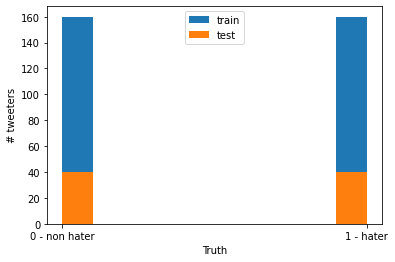

In [88]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(agg_df["tweet_lemmatized"],
                                                    agg_df["truth"],
                                                    test_size=0.2,
                                                    random_state=63,
                                                    stratify=agg_df["truth"])
print(X_train.shape)
print(X_test.shape)

plt.hist(y_train.astype(int), histtype="stepfilled", label="train")
plt.hist(y_test.astype(int), histtype="stepfilled", label="test")
plt.xticks([0, 1], ["0 - non hater", "1 - hater"])
plt.xlabel("Truth")
plt.ylabel("# tweeters")
plt.legend(loc='upper center');

## transform tweets into tfidf 

Laszlo , possible steps: remove stop words, then lemmatization etc

In [89]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(X_train)
print(tfidf_matrix.shape)

(320, 42742)


In [90]:
len(tfidf_vectorizer.get_feature_names_out())

42742

In [97]:
tfidf_vectorizer.vocabulary_["asshole"]

2856

In [98]:
tfidf_vectorizer.get_feature_names_out()[2856] # which word has id 10476

'asshole'

In [100]:
tfidf_matrix[:, 2856].count_nonzero()  # how often does the word "asshole" appear in the entire corpus

15

## Predicting a binary classification

In [94]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(TfidfVectorizer(), RidgeClassifier())
cross_val_score(pipe, X_train, y_train).mean()

0.71875

/shared-libs/python3.7/py/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


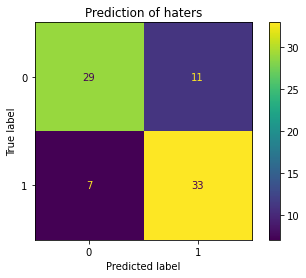

In [95]:
from sklearn.metrics import plot_confusion_matrix

pipe.fit(X_train, y_train)
plot_confusion_matrix(pipe, X_test, y_test, values_format="")
plt.title("Prediction of haters");

## Setup RF 

## run data through RF

## analyse the outcomes

![Picture title](image-20211124-095813.png)

# LSTM model

## build LSTM model

In [96]:
# DRAFT Ul this needs to be corrected
# model = Sequential( )
# embedding_neurons = 64
# model.add(tensorflow.keras.layers.Embedding(input_dim= xxx, output_dim=embedding_neurons))  
# LSTM_neurons = 250  # commonly used for GRU
# model.add(tensorflow.keras.layers.LSTM(LSTM_neurons , return_sequences=True)) 
# dense_neurons = xxx    # how many untis???
# model.add(tensorflow.keras.layers.TimeDistributed(tensorflow.keras.layers.Dense(dense_neurons, activation='softmax')))  

import tensorflow
# Input for variable-length sequences of integers
inputs = tensorflow.keras.Input(shape=(None,), dtype="int32")
# Embed each integer in a 128-dimensional vector
x = tensorflow.keras.layers.Embedding(max_features, 128)(inputs)
# Add 2 bidirectional LSTMs
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
# Add a classifier
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()

NameError: name 'max_features' is not defined

## run data through LSTM

## analyze the outcomes

# Compare the results using F1 measure

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d542cd96-5114-4360-b07a-18b11b986ecd' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>